In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
 
warnings.filterwarnings("ignore")

In [5]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

* 밝기 온도 채널만 사용해보기 위해 0~8 채널만 불러오기
* 약 7만장의 전체 데이터를 사용하지 않고, 50개 이상의 픽셀에 강수량이 기록되어 있는 이미지만 사용해보기

In [ ]:
def trainGenerator():
    
    train_path = 'train'
    train_files = sorted(glob.glob(train_path + '/*'))
    
    for file in train_files:
        
        dataset = np.load(file)
        
        target= dataset[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target)
        feature = dataset[:,:,:9]
        
        if (cutoff_labels > 0).sum() < 50:
            
            continue

        yield (feature, cutoff_labels)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([40,40,9]),tf.TensorShape([40,40,1])))

In [ ]:
train_dataset = train_dataset.batch(512).prefetch(1)

In [ ]:
test_path = 'test'
test_files = sorted(glob.glob(test_path + '/*'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    
    data = np.load(file)
    
    X_test.append(data[:,:,:9])
                  
X_test = np.array(X_test)

## 2. 데이터 전처리
### Data Cleansing & Pre-Processing

* 데이터 불러올 시 전처리 로직 적용
* 강수량에 결측값은 0으로 일괄 대체

## 3. 탐색적 자료분석
### Exploratory Data Analysis

In [14]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [11]:
image_sample = np.load('./data/subset_010462_01.npy')

In [12]:
image_sample.shape

(40, 40, 15)

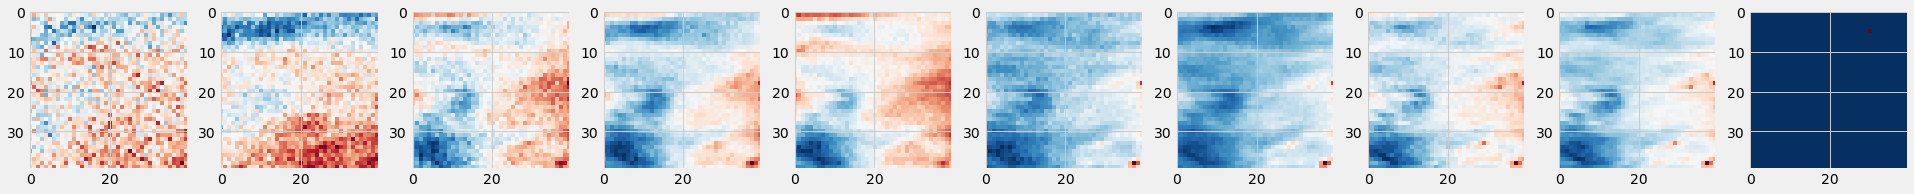

In [15]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 30))

for i in range(9):
    plt.subplot(1,10,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,10,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

## 4. 변수 선택 및 모델 구축

### Feature Engineering & Initial Modeling
* 모델 구축
* 활용한 코드1 [클릭](https://www.kaggle.com/kmader/baseline-u-net-model-part-1) <- ctrl 누른 상태에서 왼쪽 마우스 클릭
* 활용한 코드2 [클릭](https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification) <- ctrl 누른 상태에서 왼쪽 마우스 클릭

In [ ]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 9))
output_layer = build_model(input_layer, 32)

In [ ]:
model = Model(input_layer, output_layer)

* Loss fuction 정의
* 활용한 코드 [클릭](https://dacon.io/competitions/official/235584/codeshare/738) <- ctrl 누른 상태에서 왼쪽 마우스 클릭

In [ ]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [ ]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 5. 모델 학습 및 검증
### Model Tuning & Evaluation

In [ ]:
model_history = model.fit(train_dataset, epochs = 2, verbose=1)

In [ ]:
pred = model.predict(X_test)

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [ ]:
submission.to_csv('Dacon_baseline.csv', index = False)

## 6. 결과 및 결언
### Conclusion & Discussion